# 📂 Task 2: Clustering & Topic Analysis

### 📝 Overview
While Task 1 focused on extracting specific details, **Task 2** focuses on the "Big Picture." 
* **Goal:** Automatically group similar documents (or text sections) together without human labeling.
* **Analogy:** Imagine having a pile of unlabelled technical notes. This algorithm sorts them into neat stacks like "Database Errors," "Performance Tuning," and "Installation," and then labels what each stack is about.

---

### 🧪 Tech Stack & Libraries
| Library | Role in Pipeline |
| :--- | :--- |
| **`Scikit-Learn`** | The core ML engine. Used for **TF-IDF** (vectorization), **K-Means** (clustering), and **NMF** (topic modeling). |
| **`LangChain`** | Used to split the single large KBA file into smaller "chunks" to simulate a multi-document dataset. |
| **`Matplotlib`** | Visualizes the clusters in a 2D scatter plot. |
| **`BeautifulSoup`** | Cleans HTML tags to ensure the model analyzes distinct words, not code. |

---

### 🚀 Workflow: From Text to Topics
1.  **Segmentation:** Split the large KBA into smaller chunks (500 characters) to create a dataset.
2.  **Vectorization:** Convert text into numbers using **TF-IDF**.
3.  **Clustering:** Group these vectors using **K-Means**.
4.  **Topic Modeling:** Identify the hidden "themes" in each group using **NMF**.
5.  **Visualization:** Project the high-dimensional data onto a 2D map using **t-SNE**.

---

### 🧠 Technical Logic & Solutions

#### 1. Text Vectorization (TF-IDF)
* **Logic:** Computers can't read words. We used **Term Frequency-Inverse Document Frequency (TF-IDF)** to convert text into a matrix of numbers.
* **Why:** It highlights important, rare words (like "deadlock") while ignoring common noise (like "the", "and").

#### 2. K-Means Clustering
* **Logic:** We asked the algorithm to find `k=3` distinct groups in the data.
* **Outcome:** The algorithm iteratively moves "centroids" until it finds tight groups of related text chunks (e.g., separating "Symptoms" from "Resolutions").

#### 3. Topic Modeling (NMF)
* **Logic:** We applied **Non-Negative Matrix Factorization (NMF)** on the clusters.
* **Outcome:** Unlike K-Means which just groups data, NMF tells us *why* they are grouped by extracting top keywords (e.g., *Topic 1 keywords: "Memory, Leak, Allocation"*).

#### 4. Visualization (t-SNE)
* **Logic:** Our data exists in hundreds of dimensions (one for each word). We used **t-SNE** to squash this down to X and Y coordinates.
* **Result:** A scatter plot where colors represent clusters. If dots of the same color are close together, the clustering was successful.

> **Key Takeaway:** This approach allows us to discover hidden patterns and organize thousands of SAP documents automatically, paving the way for advanced RAG (Retrieval-Augmented Generation) systems.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from langchain_text_splitters import RecursiveCharacterTextSplitter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE

c:\Users\HP\anaconda3\envs\torch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_and_clean_data(file_path):
    """
    Loads JSON and cleans HTML content.
    Returns a list of text chunks to simulate 'documents' for clustering.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # 1. Extract raw text from sections (Symptom, Cause, etc.)
    full_text = ""
    if 'texts' in data:
        for section in data['texts']:
            soup = BeautifulSoup(section.get('text', ''), "html.parser")
            # We keep the title to help the model identify context
            full_text += f"{section.get('title', '')} " + soup.get_text(separator=" ", strip=True) + "\n\n"
            
    # 2. Split into chunks (Treating chunks as 'documents' for clustering demo)
    # In a real scenario, you would pass a list of full KBAs here.
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500, 
        chunk_overlap=50
    )
    chunks = text_splitter.split_text(full_text)
    
    print(f"Data loaded. Split single KBA into {len(chunks)} chunks for analysis.")
    return chunks

In [3]:
def apply_clustering(chunks, n_clusters=3):
    """
    Vectorizes text and applies K-Means clustering.
    """
    # TF-IDF Vectorization
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(chunks)
    
    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(tfidf)
    
    print(f"Clustering complete with {n_clusters} clusters.")
    return kmeans, tfidf, tfidf_vectorizer

In [10]:
def extract_topics(tfidf, vectorizer, n_topics=3):
    """
    TOPIC MODELING (LDA & NMF)
    Applies NMF (Non-Negative Matrix Factorization) to find latent topics.
    """
    nmf = NMF(n_components=n_topics, random_state=42)
    nmf_features = nmf.fit_transform(tfidf)
    
    feature_names = vectorizer.get_feature_names_out()
    
    topics = {}
    for topic_idx, topic in enumerate(nmf.components_):
        top_features_ind = topic.argsort()[:-6:-1] # Top 5 words
        top_words = [feature_names[i] for i in top_features_ind]
        topics[f"Topic {topic_idx+1}"] = top_words
        
    return topics, nmf_features

In [ ]:
def analyze_clusters(chunks, kmeans_labels, topics):
    """
    ANALYSIS & SUMMARIZATION (GraphRAG Style)
    Summarizes each cluster based on its dominant topic and content.
    """
    df = pd.DataFrame({'text': chunks, 'cluster': kmeans_labels})
    
    print("\n=== Cluster Analysis ===")
    for cluster_id in sorted(df['cluster'].unique()):
        cluster_docs = df[df['cluster'] == cluster_id]['text'].tolist()
        
        # Simple extraction-based summary (taking the first sentence of the first doc)
        # In a real setup, you would pass 'cluster_docs' to an LLM like GPT-4 here.
        summary_preview = cluster_docs[0][:100] + "..."
        
        print(f"\nCluster {cluster_id}:")
        print(f"  - Count: {len(cluster_docs)} chunks")
        print(f"  - Key Terms (from Topic {cluster_id+1} approx): {topics.get(f'Topic {cluster_id+1}', 'N/A')}")
        print(f"  - Representative Content: \"{summary_preview}\"")

In [5]:
def visualize_clusters(tfidf_matrix, labels):
    """
    Reduces dimensions using t-SNE to visualize clusters in 2D space.
    """
    tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate=200.0)
    reduced_data = tsne.fit_transform(tfidf_matrix.toarray())
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
    plt.title("K-Means Clustering of KBA Chunks")
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()

Data loaded. Split single KBA into 724 chunks for analysis.
Clustering complete with 3 clusters.

=== Cluster Analysis ===

Cluster 0:
  - Count: 123 chunks
  - Key Terms (from Topic 1 approx): ['sap', 'note', 'select', 'table', 'update']
  - Representative Content: "Symptom SQL statements run for a long time or consume a high amount of resources in terms of memory ..."

Cluster 1:
  - Count: 510 chunks
  - Key Terms (from Topic 2 approx): ['sql', 'statement', 'statements', 'trace', 'cache']
  - Representative Content: "Contains the execution time (open + fetch + lock wait + close) on SAP HANA server side, does not inc..."

Cluster 2:
  - Count: 91 chunks
  - Key Terms (from Topic 3 approx): ['00', 'column', 'hana', 'sap', 'index']
  - Representative Content: "OData and the SAP Gateway Foundation, e.g. Fiori. If you want to optimize ABAP coding for SAP HANA, ..."


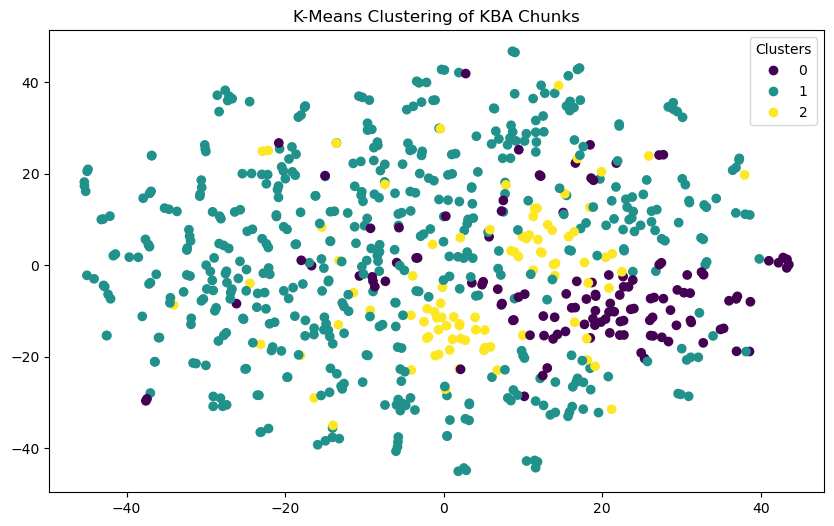

In [11]:
file_path = '../2000002.json' 

# 1. Load & Split
# We treat chunks as 'documents' because we only have one file. 
# In production, you'd load list of chunks from multiple files.
doc_chunks = load_and_clean_data(file_path)

# 2. Clustering
if len(doc_chunks) > 3:
    k = 3 # Use 3 clusters for demonstration
    model, matrix, vec = apply_clustering(doc_chunks, n_clusters=k)

    # 3. Topic Modeling
    extracted_topics, topic_dist = extract_topics(matrix, vec, n_topics=k)
    
    # 4. Analysis
    analyze_clusters(doc_chunks, model.labels_, extracted_topics)
    
    # 5. Visuals
    visualize_clusters(matrix, model.labels_)
else:
    print("Not enough data chunks to perform clustering. Try reducing chunk_size.")